In [1]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
#load datasets
dataset_jan = pd.read_parquet('yellow_tripdata_2022-01.parquet')
dataset_feb = pd.read_parquet('yellow_tripdata_2022-02.parquet')
dataset_jan.to_csv('ytd-01.csv')
dataset_feb.to_csv('ytd-02.csv')

In [3]:
df_train = pd.read_csv('ytd-01.csv')
df_val = pd.read_csv('ytd-02.csv')

C:\Users\navra\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#1. Read the data for January. How many columns are there?
df_train.drop(['Unnamed: 0'],axis=1,inplace=True)
df_val.drop(['Unnamed: 0'],axis=1,inplace=True)
columns = df_train.columns
print("How many columns are there?",len(columns))

How many columns are there? 19


In [5]:
#2. Now let's compute the duration variable. It should contain the duration of a ride in minutes.
##What's the standard deviation of the trips duration in January?
df_train['tpep_dropoff_datetime'] = pd.to_datetime(df_train['tpep_dropoff_datetime'])
df_train['tpep_pickup_datetime'] = pd.to_datetime(df_train['tpep_pickup_datetime'])

df_train['duration'] = df_train['tpep_dropoff_datetime'] - df_train['tpep_pickup_datetime']
df_train['duration'] = df_train['duration'].apply(lambda td: round(td.total_seconds()/60,3))

print("What's the standard deviation of the trips duration in January?",df_train['duration'].describe()['std'])

What's the standard deviation of the trips duration in January? 46.4453049198582


In [6]:
#applying preprocsessing on validation (feb) dataset
df_val['tpep_dropoff_datetime'] = pd.to_datetime(df_val['tpep_dropoff_datetime'])
df_val['tpep_pickup_datetime'] = pd.to_datetime(df_val['tpep_pickup_datetime'])

df_val['duration'] = df_val['tpep_dropoff_datetime'] - df_val['tpep_pickup_datetime']
df_val['duration'] = df_val['duration'].apply(lambda td: round(td.total_seconds()/60,3))

In [7]:
#Next, we need to check the distribution of the duration variable. There are some outliers. 
#Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
##3.What fraction of the records left after you dropped the outliers?

percentage_of_records_bw_1and60 = ((df_train.duration>=1) & (df_train.duration<=60)).mean()*100
print("What fraction of the records left after you dropped the outliers?",percentage_of_records_bw_1and60)


What fraction of the records left after you dropped the outliers? 98.27547930522405


In [10]:
#duration should be positive. ignoring negative values keep in between 1 to 60 min.
df_train = df_train[(df_train.duration>=1) & (df_train.duration<=60)]
df_val = df_val[(df_val.duration>=1) & (df_val.duration<=60)]

In [11]:
#after obe hot encoding
##4. What's the dimensionality of this matrix (number of columns)?
categorical = ['PULocationID','DOLocationID']
numerical = ['duration']

df_train[categorical]=df_train[categorical].astype(str)
df_val[categorical]=df_val[categorical].astype(str)

train_dict = df_train[categorical].to_dict(orient='records')
dv = DictVectorizer()
x_train = dv.fit_transform(train_dict)
y_train = df_train['duration'].values

print("What's the dimensionality of this matrix?",x_train.shape,'-->',x_train.shape[1])

What's the dimensionality of this matrix? (2918187, 514) --> 514


In [13]:
val_dict = df_val[categorical].to_dict(orient='records')
dv = DictVectorizer()
x_val = dv.fit_transform(val_dict)
y_val = df_val['duration'].values

print("What's the dimensionality of this matrix?",x_val.shape,'-->',x_val.shape[1])

What's the dimensionality of this matrix? (2918187, 514) --> 514


In [14]:
#5.What's the RMSE on train?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
lr.fit(x_train,y_train)

y_pred = lr.predict(x_train)

#root mean square value
rmse = mean_squared_error(y_train,y_pred,squared=False)
print("What's the RMSE on train?",rmse)

What's the RMSE on train? 7.639500283567648


In [15]:
yv_pred = lr.predict(x_val)
rmse_val = mean_squared_error(y_val,yv_pred,squared=False)
print("What's the RMSE on validation data?",rmse_val)

What's the RMSE on validation data? 7.639500283567648


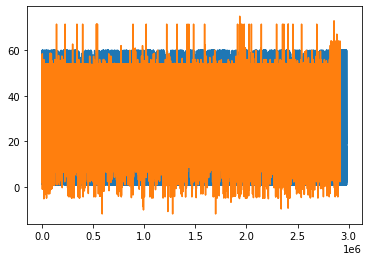

In [16]:
plt.plot(df_train['duration'])
plt.plot(y_pred)

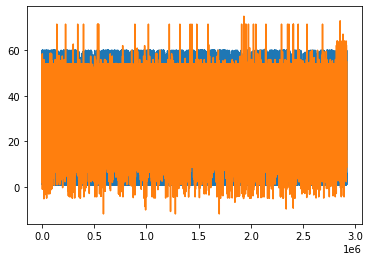

In [17]:
plt.plot(y_val)
plt.plot(yv_pred)

In [18]:
#same solution as above but create a function to do preprocessing for dataset
def read_dataframe(dataset):
    #read file
    df = pd.read_csv(dataset)
    
    #preprocessing
    ##remove index column
    df.drop(['Unnamed: 0'],axis=1,inplace=True)
    
    ##make to proper formate here to datetime
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    
    #find time duration in minutes
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df['duration'].apply(lambda td: round(td.total_seconds()/60,3))
    
    #duration should be positive. keep duration value between 1 to 60 min.
    df = df[(df.duration>=1) & (df.duration<=60)]
    
    #choose pull and drop location columns for training and make it string
    categorical = ['PULocationID','DOLocationID']
    numerical = ['duration']
    df[categorical]=df[categorical].astype(str)
    
    #make x_train and y_train
    df_dict = df[categorical].to_dict(orient='records')
    DV = DictVectorizer()
    x_columns = DV.fit_transform(df_dict)
    y_columns = df['duration'].values

    return x_columns,y_columns
    

In [19]:
x_train1,y_train1 = read_dataframe('ytd-01.csv')
x_val1,y_val1 = read_dataframe('ytd-02.csv')

C:\Users\navra\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\navra\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [20]:
lr1 = LinearRegression()
lr1.fit(x_train1,y_train1)

y_pred1 = lr1.predict(x_train1)

#root mean square value
mean_squared_error(y_train1,y_pred1,squared=False)

6.986190196098658

In [21]:
yp_test = lr1.predict(x_val1)

mean_squared_error(y_val1,yp_test,squared=False)

ValueError: dimension mismatch